In [1]:
from google.colab import drive # loads a library to mount your google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
train_data_dir = '/content/drive/MyDrive/final_data/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data

,filepaths,labels
0,/content/drive/MyDrive/final_data/Training/pit...,pituitary
1,/content/drive/MyDrive/final_data/Training/pit...,pituitary
2,/content/drive/MyDrive/final_data/Training/pit...,pituitary
3,/content/drive/MyDrive/final_data/Training/pit...,pituitary
4,/content/drive/MyDrive/final_data/Training/pit...,pituitary
...,...,...
5707,/content/drive/MyDrive/final_data/Training/gli...,glioma
5708,/content/drive/MyDrive/final_data/Training/gli...,glioma
5709,/content/drive/MyDrive/final_data/Training/gli...,glioma
5710,/content/drive/MyDrive/final_data/Training/gli...,glioma


In [4]:
test_data_dir = '/content/drive/MyDrive/final_data/Testing'
filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append (fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
dt = pd.concat([Fseries,Lseries],axis='columns')
dt

,filepaths,labels
0,/content/drive/MyDrive/final_data/Testing/notu...,notumor
1,/content/drive/MyDrive/final_data/Testing/notu...,notumor
2,/content/drive/MyDrive/final_data/Testing/notu...,notumor
3,/content/drive/MyDrive/final_data/Testing/notu...,notumor
4,/content/drive/MyDrive/final_data/Testing/notu...,notumor
...,...,...
1306,/content/drive/MyDrive/final_data/Testing/pitu...,pituitary
1307,/content/drive/MyDrive/final_data/Testing/pitu...,pituitary
1308,/content/drive/MyDrive/final_data/Testing/pitu...,pituitary
1309,/content/drive/MyDrive/final_data/Testing/pitu...,pituitary


In [5]:
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)

In [6]:
batch_size=16
img_size = (224,224)
channels = 3
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( data, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


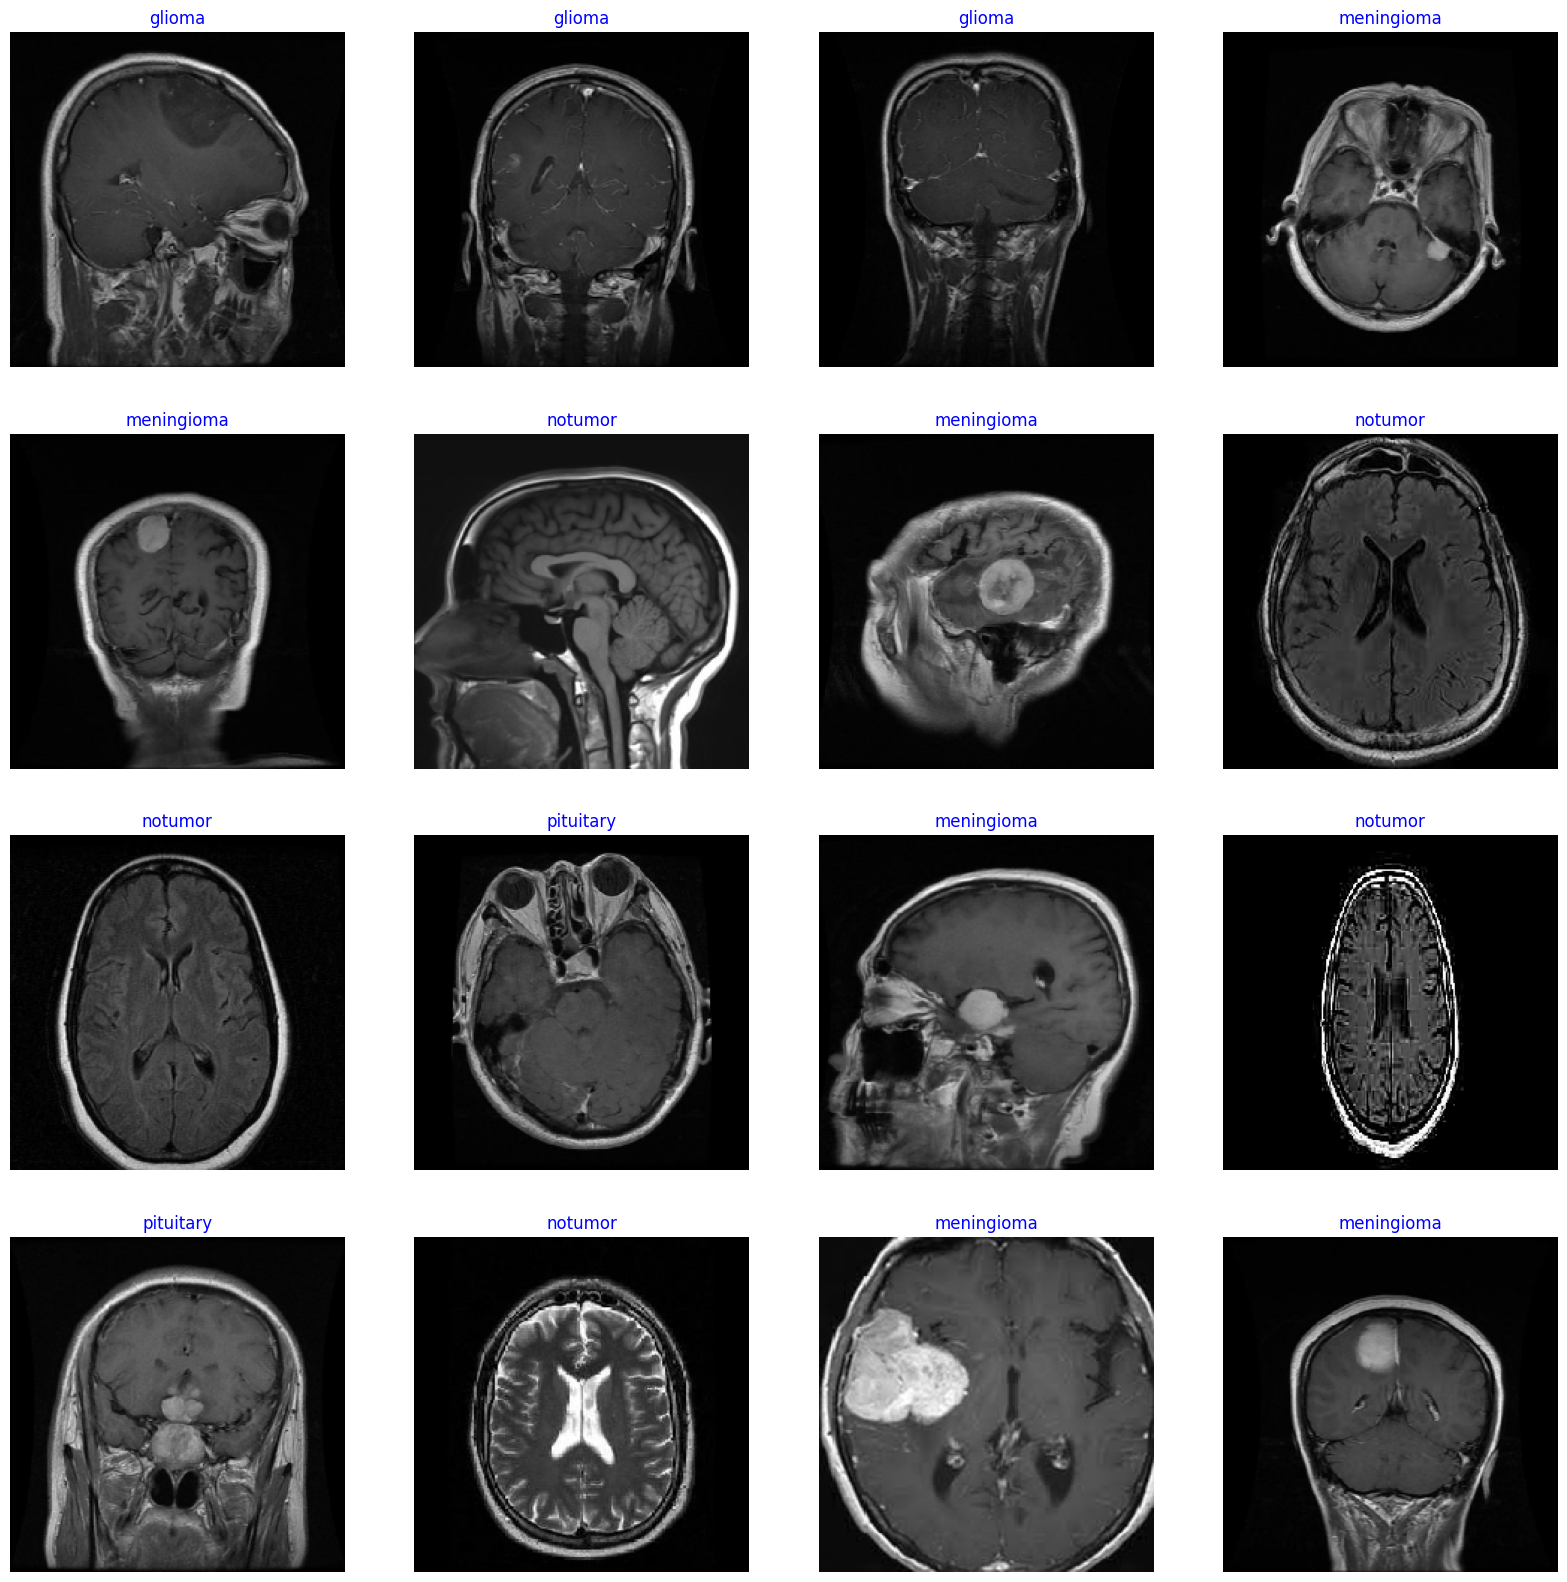

In [7]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images,labels = next(train_gen)
plt.figure(figsize = (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name= classes[index]
    plt.title(class_name,color='blue',fontsize=12)
    plt.axis('off')
plt.show();

In [8]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.VGG16(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2( 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()
Model: "VGG_16_Tumor"

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 14849092 (56.64 MB)
Trainable params: 14848

In [9]:
epochs = 35
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/35
357/357 [==============================] - 3558s 10s/step - loss: 4.2448 - accuracy: 0.6658 - val_loss: 3.3088 - val_accuracy: 0.5649
Epoch 2/35
357/357 [==============================] - 85s 237ms/step - loss: 2.1541 - accuracy: 0.7556 - val_loss: 2.1238 - val_accuracy: 0.6137
Epoch 3/35
357/357 [==============================] - 86s 241ms/step - loss: 1.3456 - accuracy: 0.8037 - val_loss: 2.4427 - val_accuracy: 0.6382
Epoch 4/35
357/357 [==============================] - 84s 236ms/step - loss: 0.9718 - accuracy: 0.8319 - val_loss: 1.7621 - val_accuracy: 0.6565
Epoch 5/35
357/357 [==============================] - 84s 234ms/step - loss: 0.7580 - accuracy: 0.8662 - val_loss: 1.2818 - val_accuracy: 0.6198
Epoch 6/35
357/357 [==============================] - 84s 234ms/step - loss: 0.5863 - accuracy: 0.8962 - val_loss: 0.6760 - val_accuracy: 0.8412
Epoch 7/35
357/357 [==============================] - 85s 237ms/step - loss: 0.4943 - accuracy: 0.9137 - val_loss: 0.8545 - val_ac

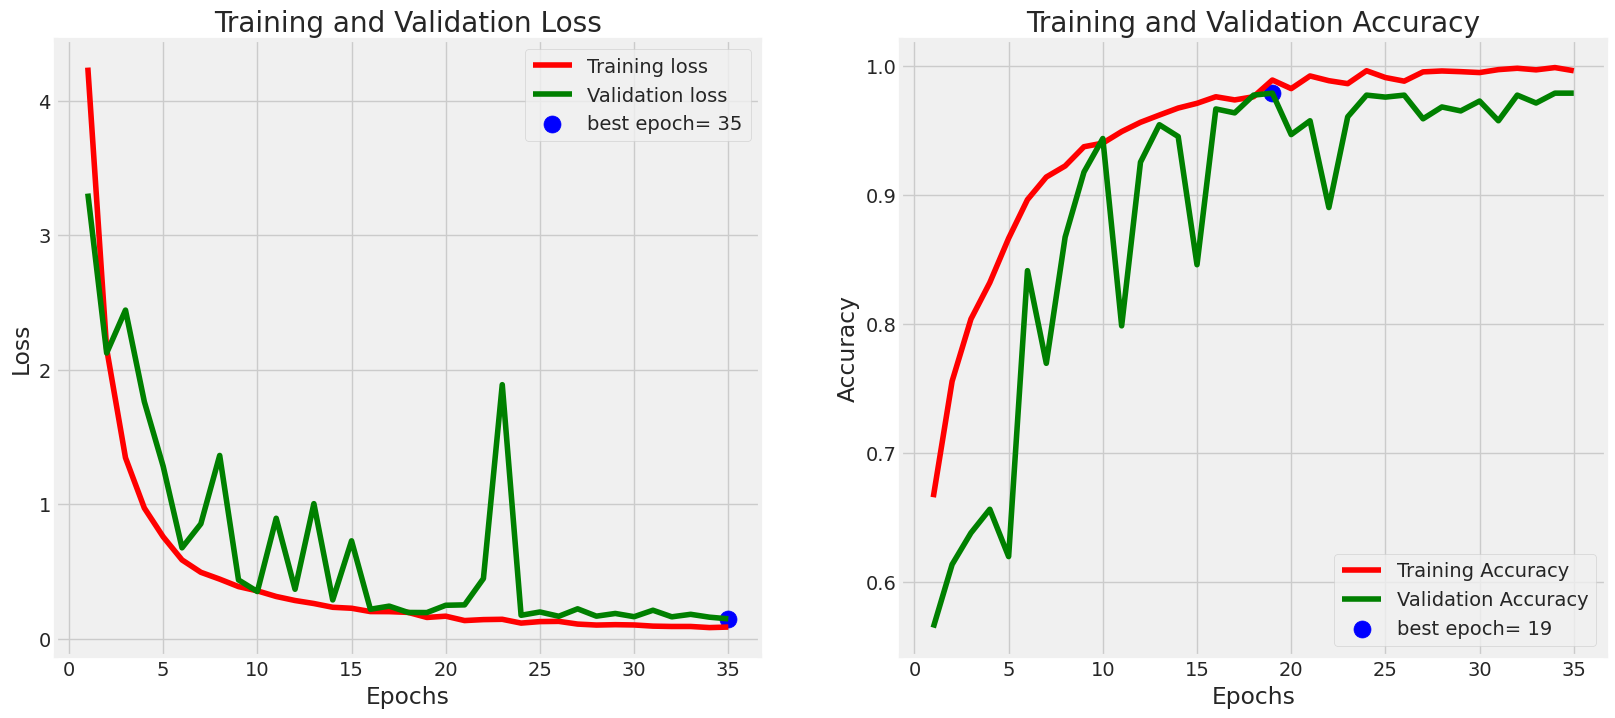

In [10]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [11]:
train_score = model.evaluate(train_gen ,  verbose = 1)
valid_score = model.evaluate(valid_gen ,  verbose = 1)
test_score = model.evaluate(test_gen ,  verbose = 1)

41/41 [==============================] - 459s 11s/step - loss: 0.1502 - accuracy: 0.9756


In [12]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 [==============================] - 4s 83ms/step


In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

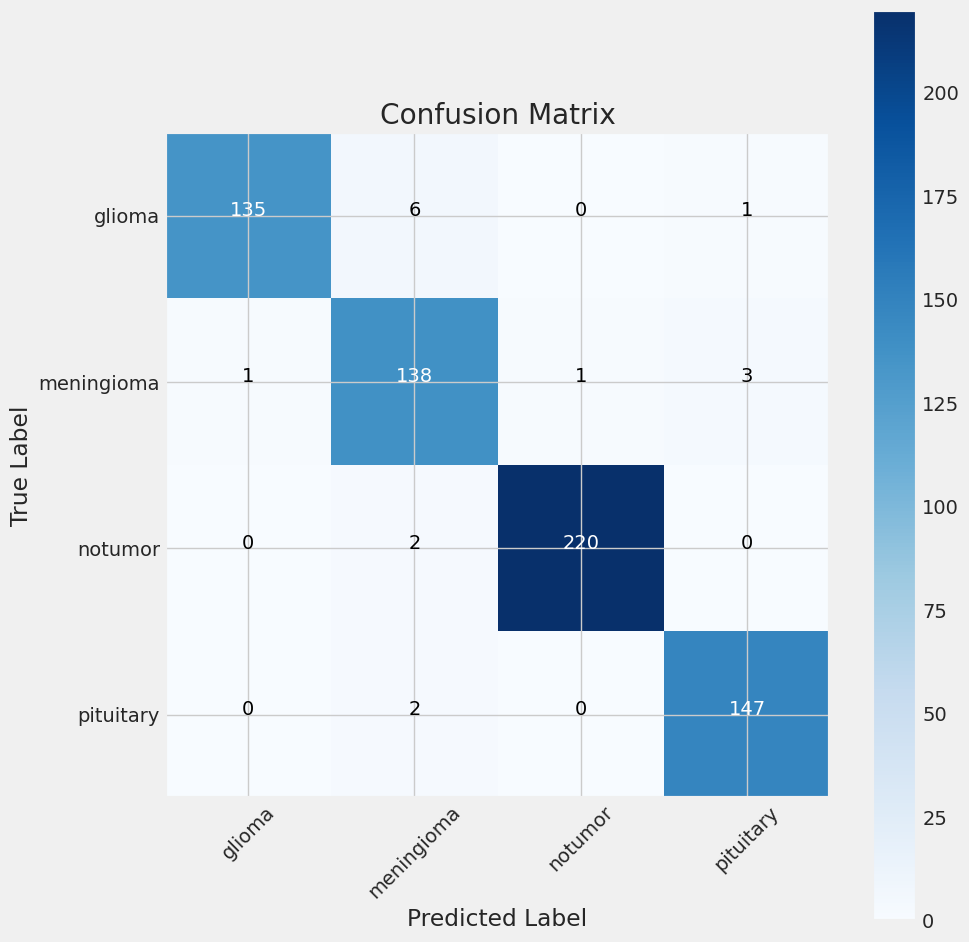

In [15]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [16]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       142
  meningioma       0.93      0.97      0.95       143
     notumor       1.00      0.99      0.99       222
   pituitary       0.97      0.99      0.98       149

    accuracy                           0.98       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.98      0.98      0.98       656



In [17]:
from tensorflow.keras.preprocessing.image import array_to_img

1/1 [==============================] - 0s 37ms/step
Image 1: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0203.jpg - predicted label 2, actual label 1


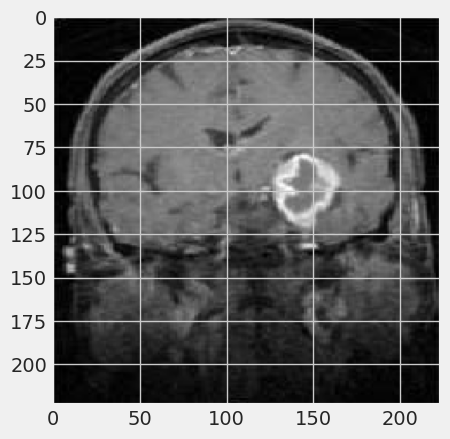

Image 2: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0148.jpg - predicted label 3, actual label 1


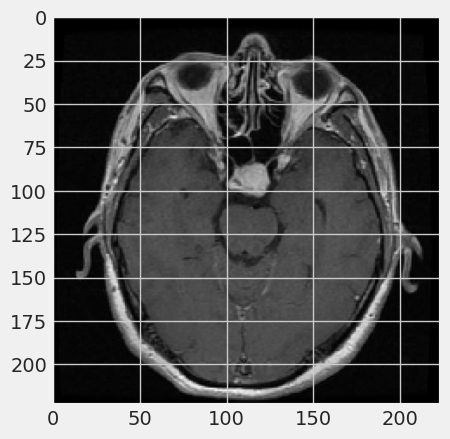

Image 3: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0203.jpg - predicted label 1, actual label 0


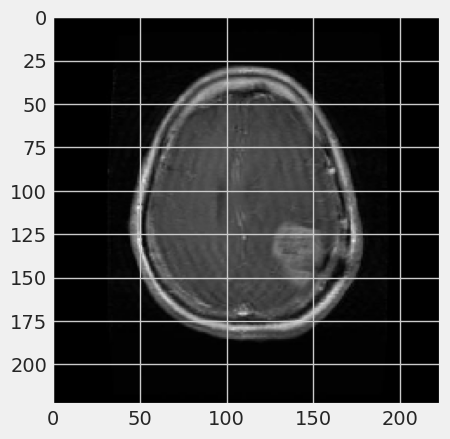

Image 4: /content/drive/MyDrive/final_data/Testing/glioma/Te-gl_0045.jpg - predicted label 1, actual label 0


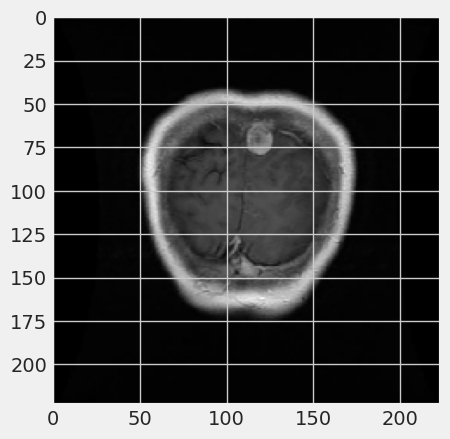

Image 5: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0203.jpg - predicted label 1, actual label 2


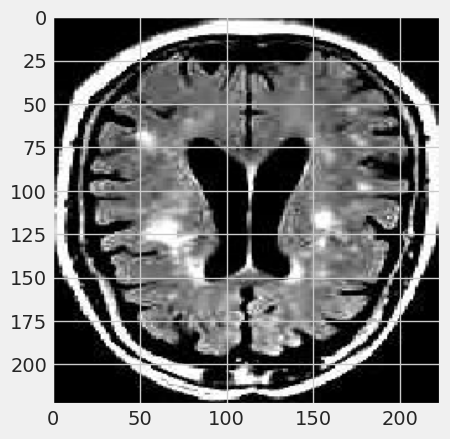

Image 6: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0106.jpg - predicted label 1, actual label 0


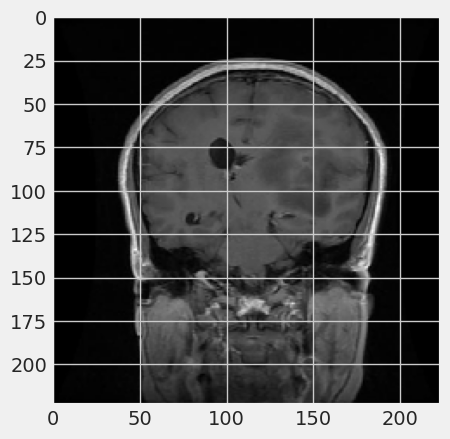

Image 7: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0240.jpg - predicted label 1, actual label 0


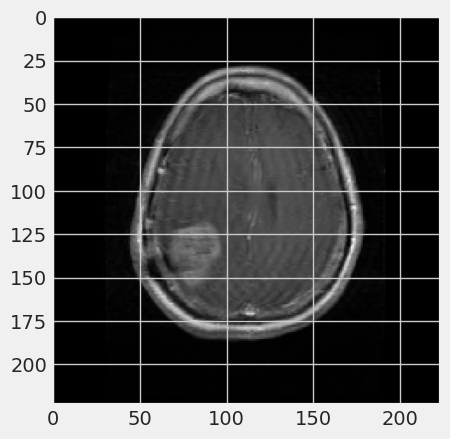

Image 8: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0015.jpg - predicted label 1, actual label 0


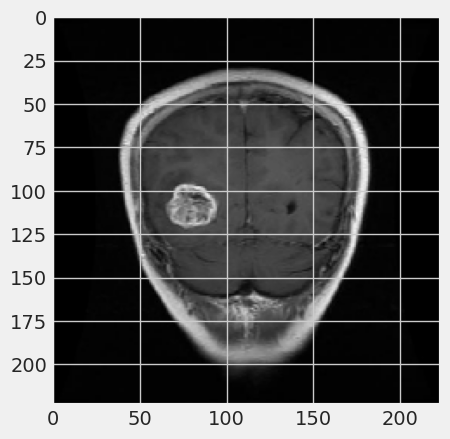

Image 9: /content/drive/MyDrive/final_data/Testing/pituitary/Te-pi_0197.jpg - predicted label 3, actual label 1


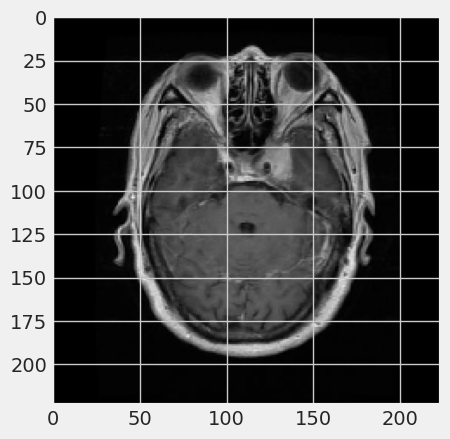

Image 10: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0148.jpg - predicted label 0, actual label 1


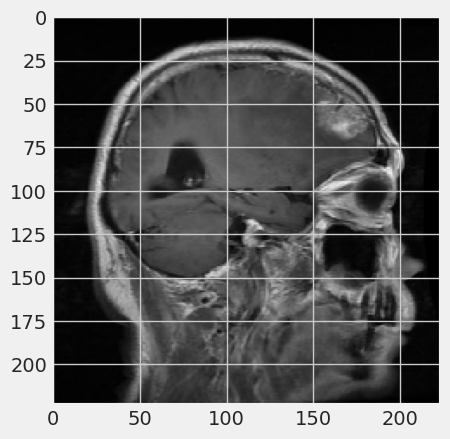

Image 11: /content/drive/MyDrive/final_data/Testing/pituitary/Te-pi_0197.jpg - predicted label 1, actual label 3


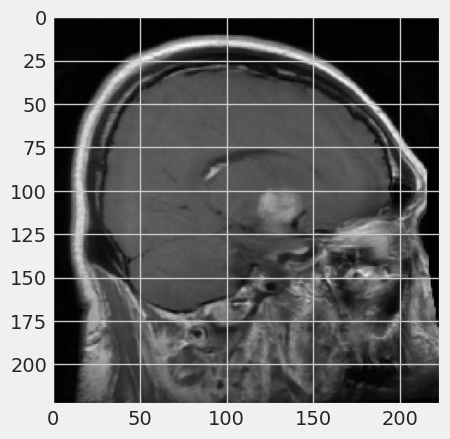

Image 12: /content/drive/MyDrive/final_data/Testing/glioma/Te-gl_0111.jpg - predicted label 1, actual label 3


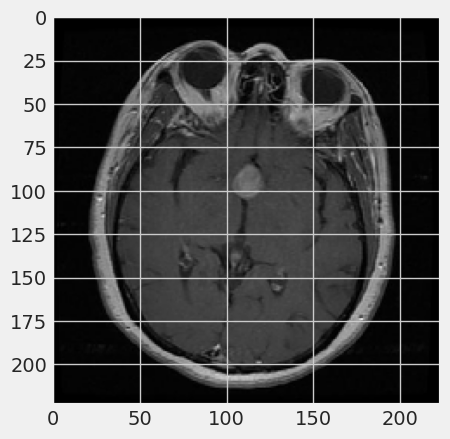

Image 13: /content/drive/MyDrive/final_data/Testing/glioma/Te-gl_0185.jpg - predicted label 3, actual label 1


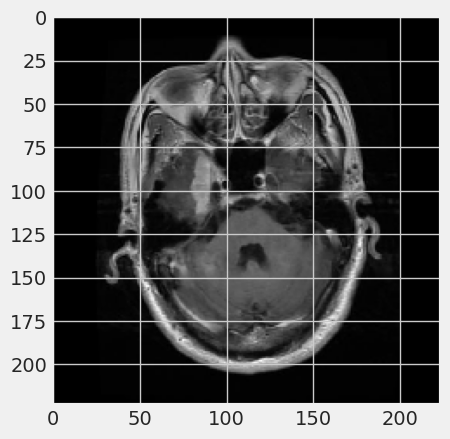

Image 14: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0035.jpg - predicted label 3, actual label 0


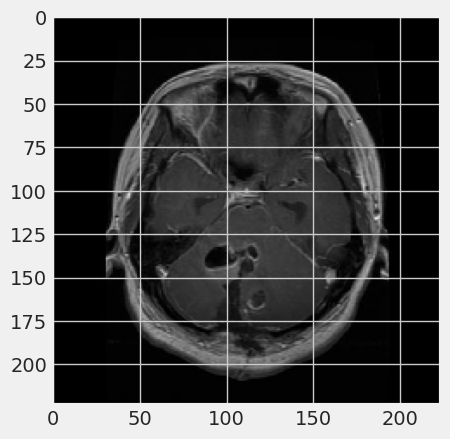

Image 15: /content/drive/MyDrive/final_data/Testing/glioma/Te-gl_0185.jpg - predicted label 1, actual label 0


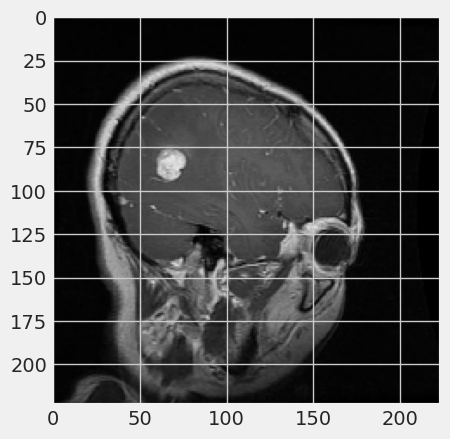

Image 16: /content/drive/MyDrive/final_data/Testing/meningioma/Te-me_0106.jpg - predicted label 1, actual label 2


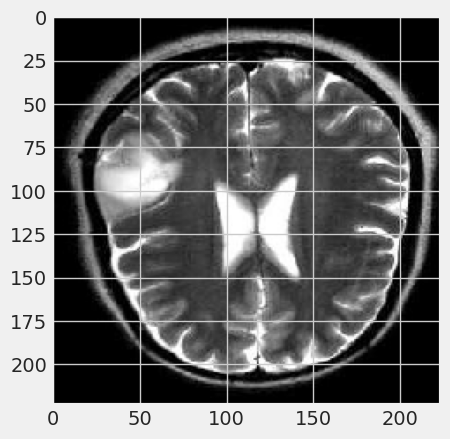

In [18]:
# Arrays to store misclassified images, predicted labels, and actual labels
misclassified_images = []
predicted_labels = []
actual_labels = []
image_names = []

# Loop over the test set
for images_batch, labels_batch in test_gen:
    # Make predictions for the current batch of images
    predictions_batch = model.predict(images_batch)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)

    # Get the actual labels
    actual_labels_batch = np.argmax(labels_batch, axis=1)
    image_names_batch = test_gen.filenames
    # Find the indices of the misclassified images
    misclassified_indices = np.where(predicted_labels_batch != actual_labels_batch)[0]

    # Store the misclassified images and their predicted and actual labels
    for i in misclassified_indices:
        misclassified_images.append(array_to_img(images_batch[i]))
        predicted_labels.append(predicted_labels_batch[i])
        actual_labels.append(actual_labels_batch[i])
        image_names.append(image_names_batch[i])

    # Stop the loop after one pass over the test set
    if test_gen.batch_index == 0:
        break

# Display the misclassified images with their predicted and actual labels
for i in range(len(misclassified_images)):
    print(f'Image {i+1}: {image_names[i]} - predicted label {predicted_labels[i]}, actual label {actual_labels[i]}')
    plt.imshow(misclassified_images[i])
    plt.show()

In [13]:
model.save('/content/drive/MyDrive/final_data/tumors_modelss/Final_VGG_16_Brain Tumor.h5')

In [19]:
# Load the saved model
model = keras.models.load_model('/content/drive/MyDrive/final_data/tumors_modelss/Final_VGG_16_Brain Tumor.h5')

# Read the test image
img = cv2.imread('/content/drive/MyDrive/final_data/Testing/meningioma/Te-meTr_0001.jpg')

# Resize the image
img = cv2.resize(img, (224, 224))

# Add a batch dimension
img = np.expand_dims(img, axis=0)

# Make predictions on the test image
predictions = model.predict(img)

# Get the predicted class
predicted_label = np.argmax(predictions)
predicted_class=classes[predicted_label]

# Print the predicted class
print("Predicted class:", predicted_class)

1/1 [==============================] - 1s 1s/step
Predicted class: meningioma
